<a href="https://colab.research.google.com/github/PuroshotamSingh/Face-Emotion-Recognition/blob/main/Facial_Emotion_Recognition_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction (Training a Face Emotion Detector Sysytem)**

**In our project we have to detect the real time emotions of students so that teachers can understand if students are able to grasp the topic according to students expressions or emotions.**

**So in our project , we first train the model on specific dataset through Convolutional Neural Network(CNN) , then with the help of opencv we capture the real time image , then apply our trained model on that image to detect the emotion of the person .
We made the frontend with the help of streamlit and deployed the entire model on Azure cloud.**

**A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.**

# **Data**

**The dataset consists of 2 folders - training and test.**

**All the images of dataset are grayscale images of size 48,48
Both these folders consist of 7 folders each- angry, disguist, fear, happy,neutral, sad, suprise.**

**All these 7 folders contain images of peoples faces with respective emotion.**

# **Importing relevent libraries**

In [1]:
# Importing libraries

import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [2]:
# to not get tensed over unnecessary warning we will ignore them

import warnings
warnings.filterwarnings('ignore')

# **Loading dataset And EDA**

**Let us do some analysis on the dataset we have. We have around 35887 images among which 28709 belong to train set and 7178 belong to test set having 7 classes each. The classes are Angry, Disgust, Fear, Happy, Neutral, Sad and Surprise. The dataset can be downloaded from https://www.kaggle.com/msambare/fer2013.**

In [3]:
# Reading zip file

from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Copy of archive.zip'

In [4]:
# Extracting zip file

with ZipFile(file_name, 'r') as zip:
  zip.extractall(path='fer13')
  print('Done')

Done


In [5]:
# Reading input path

INPUT_PATH = "/content/fer13"

In [6]:
# count of emotions

total_images = 0
for dir_ in os.listdir(INPUT_PATH + "/train/"):
    count = 0
    for f in os.listdir(INPUT_PATH + "/train/" + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

sad has 4830 number of images
surprise has 3171 number of images
happy has 7215 number of images
neutral has 4965 number of images
disgust has 436 number of images
fear has 4097 number of images
angry has 3995 number of images

total images are 28709


**The above values shows that 'Happy' images count is majority and 'Disgust' images count is in minority. So we drop minority count images from data.**

In [7]:
# Removing disgust emotion

Final_emotions = ['angry','fear','happy','neutral','sad', 'surprise']
total_images -= 436
total_images

28273

In [8]:
#Loading images into an array

img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH + "/train"):
    if dir_ in Final_emotions:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + "/train" +"/"+ dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all sad images to numpy arrays
loaded all surprise images to numpy arrays
loaded all happy images to numpy arrays
loaded all neutral images to numpy arrays
loaded all fear images to numpy arrays
loaded all angry images to numpy arrays


((28273, 48, 48, 3), array([0., 0., 0., ..., 5., 5., 5.]))

In [9]:
# so these are converted and have respective labels

label_to_text

{0: 'sad', 1: 'surprise', 2: 'happy', 3: 'neutral', 4: 'fear', 5: 'angry'}

angry
fear
happy
neutral
sad
surprise


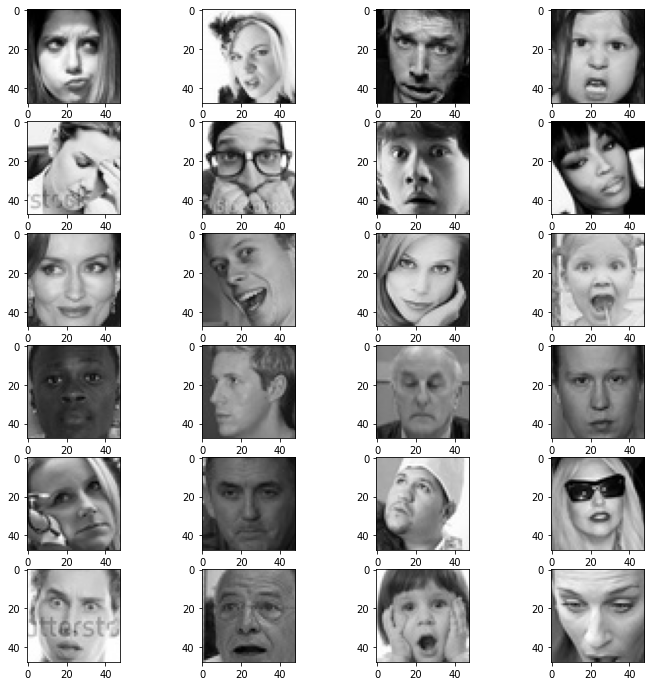

(48, 48, 3)


In [10]:
# viewing some of the images from each 

plt.figure(figsize= (12,12))
i=1
for category in Final_emotions:
  for j in range(1,5):
    plt.subplot(6,4,i)
    img = load_img(INPUT_PATH +"/"+"train/"+category+"/"+
                  os.listdir(INPUT_PATH +"/" + "train/" + category)[j], target_size=(48, 48))
    plt.imshow(img)
    i+=1
  print(category) 
plt.show()
x=img_to_array(img)
print(x.shape)

In [11]:
# Converting class vector to binary class matrix

img_label = np_utils.to_categorical(img_label)
img_label.shape

(28273, 6)

In [12]:
# Normalizing the data

img_arr = img_arr / 255.

In [13]:
# Splitting Data 

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=12)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25445, 48, 48, 3), (2828, 48, 48, 3), (25445, 6), (2828, 6))

In [14]:
#Deleting the array of images

del img_arr
del img_label

In [15]:
# Defining width, height, depth, and number of classes

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

# **Tansfer Learning- MobileNet**

**We are going to use transfer learning model called MobileNet and build our model on it.**

**We will use the weights of ImageNet, so that we end up with faster learning and good accuracy.**

In [16]:
#Defining transfer learning model

mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)


17235968/17225924 [==============================] - 0s 0us/step


* **include_top** = we have kept it as false since we didnt wanted to include the fully-connected layer at the top
* **weights** = we are using the weights of pretrained model ie imagenet, for faster learning
* **input_shape is provided as include_top is false because we will use our defined top layer as we need to change the input size for using our model.**

In [17]:
# Using mobile_net

x = mobile_net.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
output = Dense(num_classes, activation="softmax", name="out_layer")(x)
# emotion is predicted. softmax activation function is used as it will give the ranking

model = Model(inputs=mobile_net.input, outputs=output)

# **Model Summary**

In [18]:
#Summary of the model

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 24, 24, 32)        0     

* **We have (48,48,3) as the input size for our model**
* **Output layer is SoftMax layer with 4 labels.**

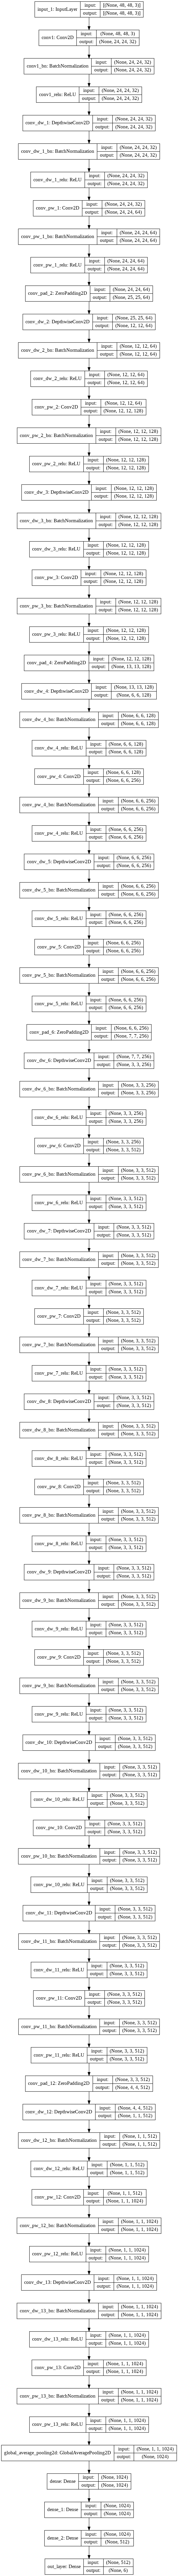

In [19]:
#Visualizing the model

tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model.png')

# **Fitting the Model**

In [20]:
# Freeze the layer

for layer in model.layers[:15]:
    layer.trainable = False  

## **Augmenting Training Images**

In [21]:
# Augumenting Training images

train_datagen = ImageDataGenerator(
    rescale =1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    zca_whitening=False,
)
train_datagen.fit(X_train)

### **We are using two callbacks:**
> **Early stopping** - To avoid overfitting of training data

> **ReduceLROnPlateau** - For Learning rate.

In [27]:
# Using callbacks to avoid overfitting

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor=['val_accuracy','val_loss'],
    min_delta=0.0001,
    factor=0.25,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    lr_scheduler]

In [28]:
#Fitting the model

batch_size = 25  
epochs = 40    # 40 epochs means model going through the entire dataset 40 times, including forward and backward propogation

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.001),
]

model.compile(
        loss='categorical_crossentropy',           # loss= categorical_crossentropy since we have more then 2 class
        optimizer=optims[1],                       # optims = to find optimal weights 
        metrics=['accuracy']                       # accuracy is criterian to improve performance
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)


Epoch 1/40
1017/1017 [==============================] - 421s 411ms/step - loss: nan - accuracy: 0.1708 - val_loss: nan - val_accuracy: 0.1708


TypeError: ignored

In [47]:

model.save("model.h5")

In [31]:
!pip install scikit-plot

test accuracy: 14.4979 %


              precision    recall  f1-score   support

           0       0.14      1.00      0.25       410
           1       0.00      0.00      0.00       722
           2       0.00      0.00      0.00       317
           3       0.00      0.00      0.00       399
           4       0.00      0.00      0.00       483
           5       0.00      0.00      0.00       497

    accuracy                           0.14      2828
   macro avg       0.02      0.17      0.04      2828
weighted avg       0.02      0.14      0.04      2828



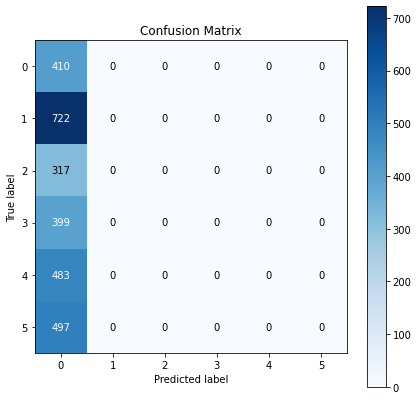

In [32]:
# Classification Report and confusion matrix

import scikitplot
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("model_confusion_matrix.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [33]:
#Fetching accuracy and loss of test and train dataset
score = model.evaluate(X_test, y_test,verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
test_image = X_test[0:1]
print (test_image.shape)

score = model.evaluate(X_train, y_train,verbose=0) 
print('Train Loss:', score[0])
print('Train accuracy:', score[1])
train_image = X_train[0:1]
print (test_image.shape)

Test Loss: nan
Test accuracy: 0.14497877657413483
(1, 48, 48, 3)
Train Loss: nan
Train accuracy: 0.14490076899528503
(1, 48, 48, 3)


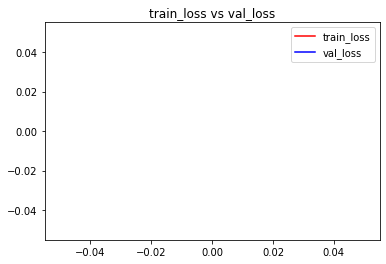

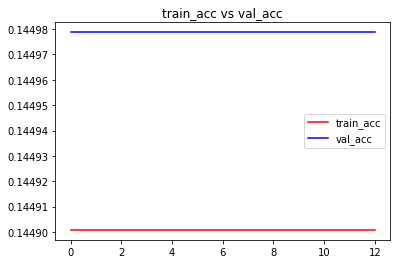

<Figure size 432x288 with 0 Axes>

In [34]:
#Visualization of model performance
import matplotlib.pyplot as plt
train_loss= history.history['loss']
val_loss= history.history['val_loss']
train_acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()
plt.savefig('model_epoch_history.png')

In [35]:
# Fetching label to text 
label_to_text

{0: 'fear', 1: 'happy', 2: 'surprise', 3: 'angry', 4: 'sad', 5: 'neutral'}

In [36]:
#Converting label_to_text to text_to_label
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'angry': 3, 'fear': 0, 'happy': 1, 'neutral': 5, 'sad': 4, 'surprise': 2}

test accuracy: 14.4979 %


              precision    recall  f1-score   support

           0       0.14      1.00      0.25       410
           1       0.00      0.00      0.00       722
           2       0.00      0.00      0.00       317
           3       0.00      0.00      0.00       399
           4       0.00      0.00      0.00       483
           5       0.00      0.00      0.00       497

    accuracy                           0.14      2828
   macro avg       0.02      0.17      0.04      2828
weighted avg       0.02      0.14      0.04      2828



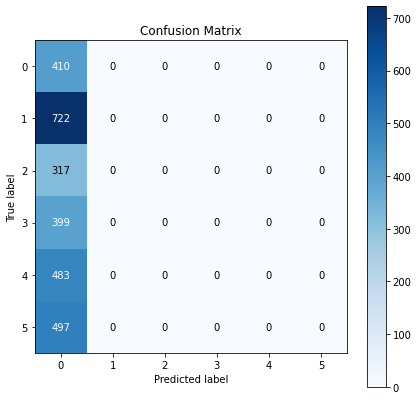

In [37]:
# Classification Report and confusion matrix
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("model_confusion_matrix.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [39]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]
        
        
        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

TypeError: ignored

<Figure size 1296x288 with 0 Axes>

In [41]:
np.random.seed(42)
neutral_imgs = np.random.choice(np.where(y_test[:, text_to_label["neutral"]]==1)[0], size=9, replace=False)
happy_imgs = np.random.choice(np.where(y_test[:, text_to_label["happy"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(neutral_imgs, happy_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Neutral, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]
        
        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:Happy, p:{pred}")

        pyplot.tight_layout()

TypeError: ignored

<Figure size 1296x288 with 0 Axes>